
## This Notebook is a sort of tutorial for the beginners in Deep Learning and time-series data analysis. 

##  * The aim is just to show how to build the simplest Long Short-Term Memory (LSTM) recurrent neural network for the data.  
 
### * Jupyter notebook can be downloaded here: https://github.com/amirrezaeian/Individual-household-electric-power-consumption-Data-Set-

The description of data can be found here:
http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

Attribute Information:
1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.global_active_power: household global minute-averaged active power (in kilowatt)

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [12]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib.dates as mdates
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
#from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout


In [22]:
df = pd.read_csv('../input/teresopolis-2016-2023-precos-medios.csv', sep=',', 
                 parse_dates={'dt' : ['Dia', 'Mês', 'Ano']},
                 low_memory=False, na_values=['nan','?'], index_col='dt')

df.index = df.index.tz_localize("America/Sao_Paulo")
df['week'] = df.index.isocalendar().week

filtered_alface_crespa_roca = df[df['Produto'] == 'Alface Crespa - Roça'][['Preco_unitario', 'week']]
filtered_alface_crespa_roca.sort_values(by=['dt'], inplace=True)
filtered_alface_crespa_roca

/tmp/ipykernel_1687341/3566122185.py:1: UserWarning: Parsing dates in %d %m %Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('../input/teresopolis-2016-2023-precos-medios.csv', sep=',',


,Preco_unitario,week
dt,,
2016-04-22 00:00:00-03:00,0.61650,16
2016-04-29 00:00:00-03:00,0.42611,17
2016-05-06 00:00:00-03:00,0.43778,18
2016-05-13 00:00:00-03:00,0.43056,19
2016-05-20 00:00:00-03:00,0.44444,20
...,...,...
2023-08-25 00:00:00-03:00,0.40833,34
2023-08-31 00:00:00-03:00,0.37500,35
2023-09-08 00:00:00-03:00,0.35417,36


In [ ]:
weather_df = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2022_A_31-12-2022.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')

weather_df.index = weather_df.index.tz_convert("America/Sao_Paulo")

#weather_df = weather_df[weather_df.index >= '2022-01-07']
weather_weekly_df = pd.DataFrame(weather_df[ 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].resample('W').mean())
weather_weekly_df['week'] = weather_weekly_df.index.isocalendar().week
weather_weekly_df

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",week
dt,,
2022-01-02 00:00:00-03:00,0.439216,52
2022-01-09 00:00:00-03:00,1.128571,1
2022-01-16 00:00:00-03:00,0.670238,2
2022-01-23 00:00:00-03:00,0.052381,3
2022-01-30 00:00:00-03:00,0.190476,4
2022-02-06 00:00:00-03:00,0.761905,5
2022-02-13 00:00:00-03:00,1.065476,6
2022-02-20 00:00:00-03:00,0.647619,7
2022-02-27 00:00:00-03:00,0.434524,8


<Axes: xlabel='dt'>

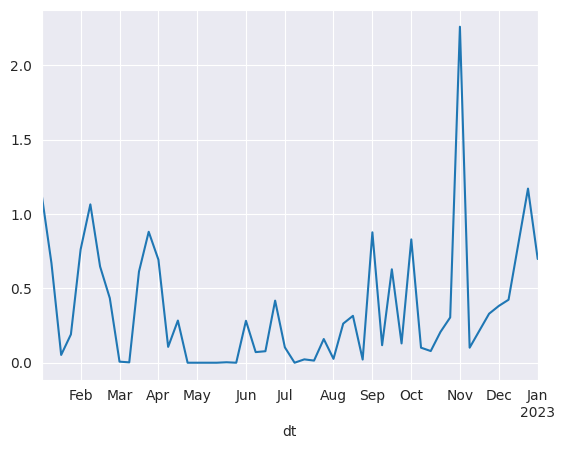

In [27]:
weather_weekly_df[weather_weekly_df.index >= '2022-01-07']['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].plot()

In [26]:

filtered_alface_crespa_roca.Preco_unitario.resample('W').mean().plot(title='Média Preço unitário x Semana', color='red') 
plt.tight_layout()
plt.show()

#filtered_alface_crespa_roca.precip.resample('W').mean().plot(title='Média de precipitação x Semana', color='red') 
#plt.tight_layout()
#plt.show()

NonExistentTimeError: 2016-10-16 00:00:00

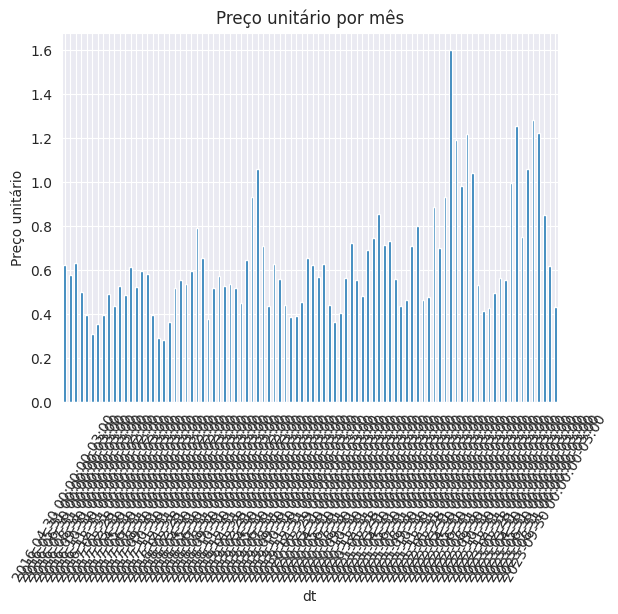

In [28]:
### Sum of 'Global_active_power' resampled over month
# Sum of 'Global_active_power' resampled over month
df['Preco_unitario'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Preço unitário')
plt.title('Preço unitário por mês')
plt.show()

In [ ]:
precos_2023 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2023-01-01')& (filtered_alface_crespa_roca.index < '2023-12-31')]

precos_2022 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2022-01-01')& (filtered_alface_crespa_roca.index < '2022-12-31')]

precos_2021 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2021-01-01')& (filtered_alface_crespa_roca.index < '2021-12-31')]

#.plot(title='Soma Preço unitário x Semana')
plt.figure(figsize=(15, 10))


plt.subplot(3, 1, 1)
plt.plot(precos_2023.Preco_unitario.resample('W').mean())
plt.title("2023", y=0.75, loc='right')

plt.subplot(3, 1, 2)
plt.plot(precos_2022.Preco_unitario.resample('W').mean())
plt.title("2022", y=0.75, loc='right')

plt.subplot(3, 1, 3)
plt.plot(precos_2021.Preco_unitario.resample('W').mean())
plt.title("2021", y=0.75, loc='right')


Text(1.0, 0.75, '2021')

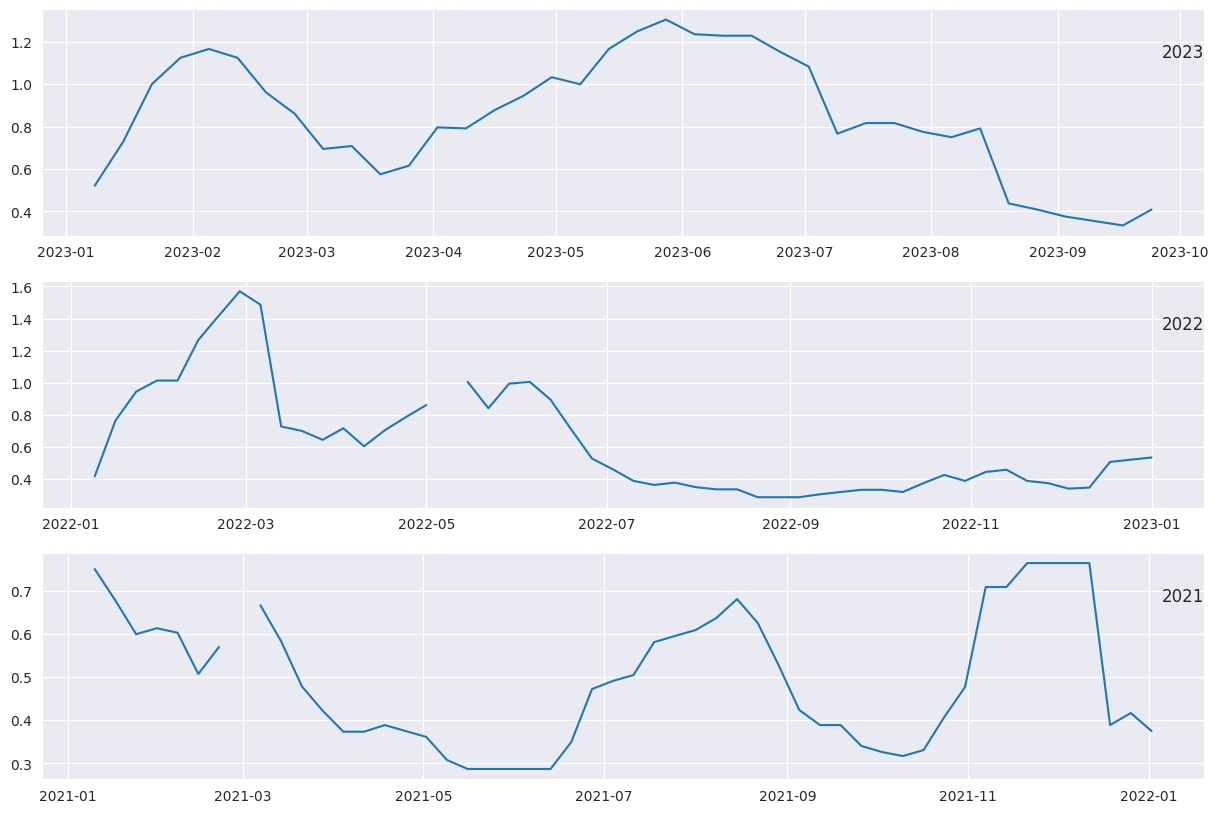

In [ ]:
# Below I show hist plot of the mean of different feature resampled over month 
filtered_alface_crespa_roca.Preco_unitario.resample('M').mean().plot(kind='hist', color='r', legend=True )
filtered_alface_crespa_roca.precip.resample('M').mean().plot(kind='hist',color='b', legend=True)


plt.show()

In [ ]:
## The correlations between 'Global_intensity', 'Global_active_power'
data_returns = filtered_alface_crespa_roca.pct_change()
sns.jointplot(x='Preco_unitario', y='precip', data=data_returns)  

plt.show()

# Correlations among features

In [ ]:
# Correlations among columns
plt.matshow(filtered_alface_crespa_roca.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

In [ ]:
# Correlations of mean of features resampled over months


plt.matshow(df.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()

# Machine-Leaning: LSTM Data Preparation and feature engineering

### * I will apply recurrent nueral network (LSTM) which is best suited for time-seriers and sequential problem. This approach is the best if we have large data.  

### * I will frame the supervised learning problem as predicting the Global_active_power at the current time (t) given the Global_active_power measurement and other features at the prior time step.

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [ ]:
## resampling of data over hour
#df_resample = df.resample('h').mean() 
#df_resample.shape

filtered_alface_crespa_roca.shape

In [ ]:
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = filtered_alface_crespa_roca.values

n_train_time = 248
train = values[:n_train_time, :]
test = values[n_train_time:, :]



In [ ]:

## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# frame as supervised learning
reframed_train = series_to_supervised(scaled_train, 4, 4)
reframed_test = series_to_supervised(scaled_test, 4, 4)


# drop columns we don't want to predict
#reframed_train.drop(reframed_train.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
#reframed_test.drop(reframed_test.columns[[8,9,10,11,12,13]], axis=1, inplace=True)

print(reframed_train.head())
print(reframed_test.head())

### * Above I showed 7 input variables (input series) and the 1 output variable for 'Global_active_power' at the current  time in hour (depending on resampling). 

# Splitting the rest of data to train and validation sets

### * First, I split the prepared dataset into train and test sets. To speed up the training of the model (for the sake of the demonstration), we will only train the model on the first year of data, then evaluate it on the next 3 years of data.

In [ ]:
# split into train and test sets
#values = reframed.values

#n_train_time = 365*24
#train = values[:n_train_time, :]
#test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = reframed_train.values[:, :-4], reframed_train.values[:, -4]
test_X, test_y = reframed_test.values[:, :-4], reframed_test.values[:, -4]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

# Model architecture

### 1)  LSTM with 100 neurons in the first visible layer 
### 3) dropout 20%
### 4) 1 neuron in the output layer for predicting Global_active_power. 
### 5) The input shape will be 1 time step with 7 features.

### 6) I use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
### 7) The model will be fit for 20 training epochs with a batch size of 70.


In [ ]:

model = Sequential()
model.add(LSTM(500, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=40, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 4))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

### Note that in order to improve the model, one has to adjust epochs and batch_size.

In [ ]:
dates = pd.to_datetime(filtered_alface_crespa_roca.index[255:]).strftime('%d-%m-%Y')
dates = dates.to_list()
dates

In [ ]:


## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

aa=[x for x in range(124)]
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.xticks(rotation=90)
plt.plot(dates, inv_y[:124], marker='.', label="actual")
plt.plot(dates, inv_yhat[:124], 'r', label="prediction")
plt.ylabel('Preco unitario', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()